# Company A - Data Preliminary Analysis

* PCA / ICA & visualization with t-SNE
* Dense NN (no temporal dependence)
* SVM Lasso with Regularization (Recursive Feature Elimination) for Magnitude of initial feature Feature elimination  

## Import packages

In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import scipy
import sklearn

In [83]:
from tensorflow.keras.models import (Model, Sequential)
from tensorflow.keras.layers import (Input, Dense, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
#from tensorflow.keras.layers.core import Lambda
from tensorflow.keras.optimizers import (Adam, SGD)
from tensorflow.keras.regularizers import l1

## Load data & key parameters

In [347]:
data = pd.read_pickle('mod_data.pkl')
print("Column headings:")
print(data.columns)

Column headings:
Index(['Product Made', 'Air consumption', 'Gas consumption', 'Exhaust gas',
       'Speed', 'Pressure', 'Kiln Feed', 'Dust Addition',
       'Moisture Beltweigher', 'Moisture CLC', 'Additive B', 'Additive C',
       'CLC CaO', 'CLC Na2O', 'Surface Area', 'Compacite', 'd50', 'd90',
       'B₂O₃', 'Na₂O'],
      dtype='object')


In [315]:
# key metrics
col_input = ["Air consumption","Gas consumption","Exhaust gas","Speed","Pressure","Kiln Feed","Dust Addition","Moisture Beltweigher","Moisture CLC","Additive B","Additive C","CLC CaO","CLC Na2O"]
col_output_H = ["Surface Area","Compacite","d50"]
col_output_L = ["d90","B₂O₃","Na₂O"]
prod_type = ['A','B','C','D','F','G','H','I']

## (A.1) Principal Component Analysis + tSNE

##### Normalize data

In [188]:
from sklearn import preprocessing

# removing Product A (="0") because there are too many, thus dominate results
data_ = data[data["Product Made"]!=0]

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(data_.drop(["Product Made"], axis=1))
# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

##### Setup PCA and fit

In [89]:
from sklearn.decomposition import PCA
pca = PCA(8)
result = pca.fit_transform(df_normalized)

Text(0, 0.5, 'cumulative explained variance')

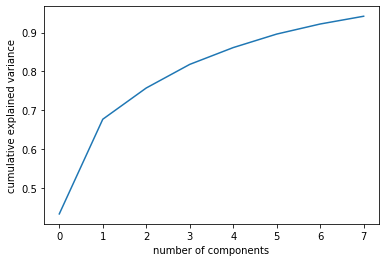

In [90]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

##### Visualize with tSNE

In [91]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=True, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(result)
tsne_results.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.002s...
[t-SNE] Computed neighbors for 382 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 0.249473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.875534
[t-SNE] KL divergence after 10000 iterations: 0.295072


(382, 3)

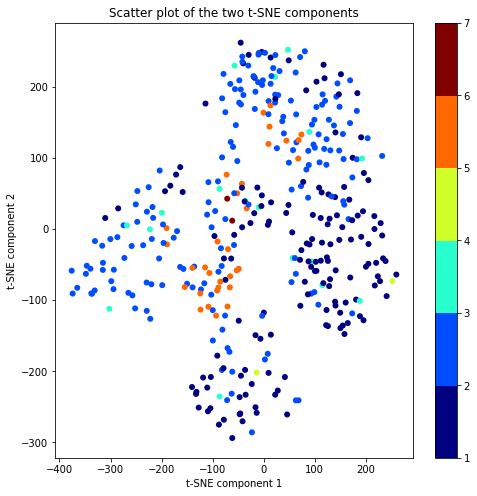

In [99]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data["Product Made"][data["Product Made"]!=0], edgecolor='none', alpha=1,
            cmap=cm.get_cmap('jet', 6))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();

## (A.2) Independent Component Analysis +tSNE

##### Normalize data

In [188]:
from sklearn import preprocessing

# removing Product A (="0") because there are too many, thus dominate results
data_ = data[data["Product Made"]!=0]

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(data_.drop(["Product Made"], axis=1))
# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

##### Setup ICA and fit

In [101]:
from sklearn.decomposition import FastICA
numICAcomp = 8
ica = FastICA(n_components=numICAcomp, max_iter=2000, tol=0.001)
ICA = ica.fit_transform(df_normalized)

##### Visualize with tSNE

In [102]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=True, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(ICA)
tsne_results.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.000s...
[t-SNE] Computed neighbors for 382 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 0.052049
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.245506
[t-SNE] KL divergence after 10000 iterations: 0.465158


(382, 3)

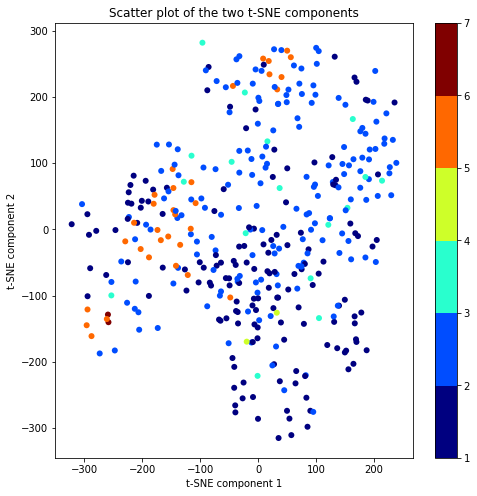

In [103]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data["Product Made"][data["Product Made"]!=0], edgecolor='none', alpha=1,
            cmap=cm.get_cmap('jet', 6))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();

## (B) Dense Neural Networks

##### Normalize data for NN

In [202]:
from sklearn import preprocessing

# removing Product A (="0") because there are too many, thus dominate results
data_in = data[col_input]
data_outH = data[col_output_H]
data_outL = data[col_output_L]

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(data_in)
x_scaled2 = min_max_scaler.fit_transform(data_outH)
# Run the normalizer on the dataframe
data_in_normalized = pd.DataFrame(x_scaled)
data_outH_normalized = pd.DataFrame(x_scaled2)

In [332]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_in_normalized), 
                                                    np.array(data["Product Made"]), 
                                                    test_size=0.33)

##### Inspect data shape 

In [333]:
print("input layer:",np.array(data_in_normalized).shape)
print("output layer:",len(data["Product Made"].unique()))
print("output layer:",len(np.unique(y_train)))

input layer: (1116, 13)
output layer: 8
output layer: 7


##### Setting up NN

In [334]:
l1_norm = 1e-4

model = Sequential()
model.add(Dense(50, input_dim=13, activation='relu', activity_regularizer=l1(l1_norm)))
for i in range(10):
    model.add(Dense(50, activation='relu', activity_regularizer=l1(l1_norm)))
model.add(Dense(8, activation='sigmoid')) # or use softmax

##### Compile NN and fit

In [336]:
# set learning rate
lr = 2e-3
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy']) # categorical loss, SGD
# fits the model
model.fit(X_train, y_train, epochs=500, batch_size=100)

Train on 747 samples
Epoch 1/500
747/747 [==============================] - 2s 3ms/sample - loss: 2.0122 - accuracy: 0.5930
Epoch 2/500
747/747 [==============================] - 0s 67us/sample - loss: 1.4710 - accuracy: 0.6600
Epoch 3/500
747/747 [==============================] - 0s 66us/sample - loss: 1.0926 - accuracy: 0.6600
Epoch 4/500
747/747 [==============================] - 0s 63us/sample - loss: 1.0540 - accuracy: 0.6600
Epoch 5/500
747/747 [==============================] - 0s 71us/sample - loss: 0.9890 - accuracy: 0.6600
Epoch 6/500
747/747 [==============================] - 0s 68us/sample - loss: 0.9520 - accuracy: 0.6600
Epoch 7/500
747/747 [==============================] - 0s 70us/sample - loss: 0.9170 - accuracy: 0.6600
Epoch 8/500
747/747 [==============================] - 0s 59us/sample - loss: 0.8963 - accuracy: 0.6600
Epoch 9/500
747/747 [==============================] - 0s 55us/sample - loss: 0.8829 - accuracy: 0.6600
Epoch 10/500
747/747 [======================

747/747 [==============================] - 0s 73us/sample - loss: 0.4867 - accuracy: 0.8193
Epoch 79/500
747/747 [==============================] - 0s 78us/sample - loss: 0.4919 - accuracy: 0.8286
Epoch 80/500
747/747 [==============================] - 0s 70us/sample - loss: 0.4669 - accuracy: 0.8474
Epoch 81/500
747/747 [==============================] - 0s 73us/sample - loss: 0.4481 - accuracy: 0.8434
Epoch 82/500
747/747 [==============================] - 0s 75us/sample - loss: 0.4453 - accuracy: 0.8474
Epoch 83/500
747/747 [==============================] - 0s 71us/sample - loss: 0.4577 - accuracy: 0.8327
Epoch 84/500
747/747 [==============================] - 0s 72us/sample - loss: 0.4530 - accuracy: 0.8420
Epoch 85/500
747/747 [==============================] - 0s 66us/sample - loss: 0.4188 - accuracy: 0.8581
Epoch 86/500
747/747 [==============================] - 0s 67us/sample - loss: 0.3905 - accuracy: 0.8621
Epoch 87/500
747/747 [==============================] - 0s 66us/samp

747/747 [==============================] - 0s 71us/sample - loss: 0.3066 - accuracy: 0.8969
Epoch 156/500
747/747 [==============================] - 0s 69us/sample - loss: 0.3102 - accuracy: 0.8942
Epoch 157/500
747/747 [==============================] - 0s 63us/sample - loss: 0.3151 - accuracy: 0.8929
Epoch 158/500
747/747 [==============================] - 0s 67us/sample - loss: 0.2719 - accuracy: 0.8969
Epoch 159/500
747/747 [==============================] - 0s 67us/sample - loss: 0.2797 - accuracy: 0.8996
Epoch 160/500
747/747 [==============================] - 0s 67us/sample - loss: 0.2430 - accuracy: 0.9130
Epoch 161/500
747/747 [==============================] - 0s 62us/sample - loss: 0.2471 - accuracy: 0.9224
Epoch 162/500
747/747 [==============================] - 0s 67us/sample - loss: 0.2802 - accuracy: 0.9009
Epoch 163/500
747/747 [==============================] - 0s 67us/sample - loss: 0.2624 - accuracy: 0.9063
Epoch 164/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 58us/sample - loss: 0.1717 - accuracy: 0.9384
Epoch 233/500
747/747 [==============================] - 0s 65us/sample - loss: 0.1756 - accuracy: 0.9384
Epoch 234/500
747/747 [==============================] - 0s 66us/sample - loss: 0.1703 - accuracy: 0.9331
Epoch 235/500
747/747 [==============================] - 0s 80us/sample - loss: 0.1981 - accuracy: 0.9250
Epoch 236/500
747/747 [==============================] - 0s 72us/sample - loss: 0.2105 - accuracy: 0.9224
Epoch 237/500
747/747 [==============================] - 0s 71us/sample - loss: 0.1825 - accuracy: 0.9304
Epoch 238/500
747/747 [==============================] - 0s 77us/sample - loss: 0.2043 - accuracy: 0.9210
Epoch 239/500
747/747 [==============================] - 0s 77us/sample - loss: 0.2098 - accuracy: 0.9304
Epoch 240/500
747/747 [==============================] - 0s 66us/sample - loss: 0.2573 - accuracy: 0.9183
Epoch 241/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 65us/sample - loss: 0.1353 - accuracy: 0.9558
Epoch 310/500
747/747 [==============================] - 0s 52us/sample - loss: 0.1408 - accuracy: 0.9531
Epoch 311/500
747/747 [==============================] - 0s 57us/sample - loss: 0.1373 - accuracy: 0.9424
Epoch 312/500
747/747 [==============================] - 0s 66us/sample - loss: 0.1762 - accuracy: 0.9344
Epoch 313/500
747/747 [==============================] - 0s 65us/sample - loss: 0.1276 - accuracy: 0.9612
Epoch 314/500
747/747 [==============================] - 0s 55us/sample - loss: 0.1470 - accuracy: 0.9451
Epoch 315/500
747/747 [==============================] - 0s 57us/sample - loss: 0.1277 - accuracy: 0.9465
Epoch 316/500
747/747 [==============================] - 0s 53us/sample - loss: 0.1044 - accuracy: 0.9665
Epoch 317/500
747/747 [==============================] - 0s 64us/sample - loss: 0.1100 - accuracy: 0.9665
Epoch 318/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 73us/sample - loss: 0.0561 - accuracy: 0.9826
Epoch 387/500
747/747 [==============================] - 0s 73us/sample - loss: 0.0547 - accuracy: 0.9880
Epoch 388/500
747/747 [==============================] - 0s 73us/sample - loss: 0.0510 - accuracy: 0.9853
Epoch 389/500
747/747 [==============================] - 0s 71us/sample - loss: 0.0654 - accuracy: 0.9772
Epoch 390/500
747/747 [==============================] - 0s 73us/sample - loss: 0.0693 - accuracy: 0.9772
Epoch 391/500
747/747 [==============================] - 0s 70us/sample - loss: 0.0569 - accuracy: 0.9826
Epoch 392/500
747/747 [==============================] - 0s 65us/sample - loss: 0.0565 - accuracy: 0.9853
Epoch 393/500
747/747 [==============================] - 0s 61us/sample - loss: 0.0675 - accuracy: 0.9719
Epoch 394/500
747/747 [==============================] - 0s 65us/sample - loss: 0.0744 - accuracy: 0.9813
Epoch 395/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 69us/sample - loss: 0.0833 - accuracy: 0.9705
Epoch 464/500
747/747 [==============================] - 0s 68us/sample - loss: 0.0687 - accuracy: 0.9786
Epoch 465/500
747/747 [==============================] - 0s 67us/sample - loss: 0.0794 - accuracy: 0.9692
Epoch 466/500
747/747 [==============================] - 0s 63us/sample - loss: 0.0628 - accuracy: 0.9759
Epoch 467/500
747/747 [==============================] - 0s 63us/sample - loss: 0.0969 - accuracy: 0.9679
Epoch 468/500
747/747 [==============================] - 0s 69us/sample - loss: 0.1244 - accuracy: 0.9652
Epoch 469/500
747/747 [==============================] - 0s 61us/sample - loss: 0.1079 - accuracy: 0.9612
Epoch 470/500
747/747 [==============================] - 0s 67us/sample - loss: 0.1480 - accuracy: 0.9478
Epoch 471/500
747/747 [==============================] - 0s 66us/sample - loss: 0.1466 - accuracy: 0.9518
Epoch 472/500
747/747 [==============================] - 0s 

##### Evaluate model

In [340]:
# Prediction
predict_raw = model.predict(X_test, verbose=0)
predict_raw.shape

(369, 8)

In [341]:
# reformat prediction (reshape index to integer)
y_predict = list()
for i in predict_raw:
    y_predict.append(list(i).index(max(i)))
y_predict = np.array(y_predict)

In [342]:
# confusion matrix
result = confusion_matrix(y_test, y_predict)
result.shape

(6, 6)

Text(0.5, 1, 'NN Confusion Matrix')

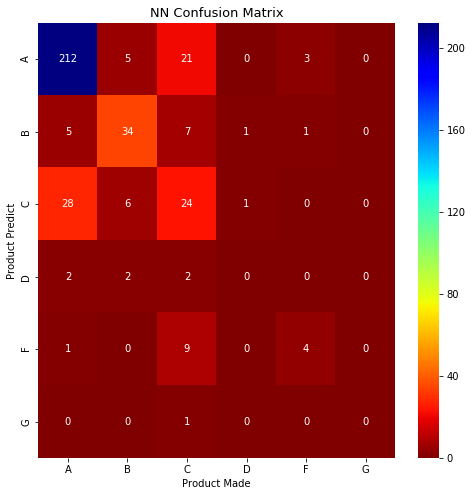

In [345]:
df_cm = pd.DataFrame(result, index = prod_type[:6], columns = prod_type[:6])
plt.figure(figsize = (8,8))
ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap='jet_r')
ax.set(xlabel='Product Made', ylabel='Product Predict')
ax.set_title("NN Confusion Matrix", fontsize=13)